<div style="text-align: center;">
    <div class="Headline" style="display: inline-block; border: 2px solid #4CAF50; border-radius: 15px; background-color: #f9f9f9; padding: 20px; box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.1);">
        <h3 style="margin: 0; text-align: center; color: #333;">
            <span id="title_page_challenge" style="font-size: 24px; font-weight: bold;">AI for Meter Reading</span>
            <br>
            <small style="font-size: 16px; color: #555;">par Yann Rousseau</small>
        </h3>
    </div>
</div>


# 1. Découverte du dataset.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile
import os
import pandas as pd
from PIL import Image
import cv2

import torch
import torch.nn as nn
from torchvision.transforms import ToTensor, ToPILImage, Resize
from torchvision import transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader

In [4]:
path = './datas/'
filepath = os.path.join(path, 'XTRAIN')
with ZipFile(os.path.join(path, 'x_train.zip'), 'r') as zipfile:
    zipfile.extractall(filepath)
    print("Files extracted and folder {} created.".format(filepath))

Files extracted and folder ./datas/XTRAIN created.


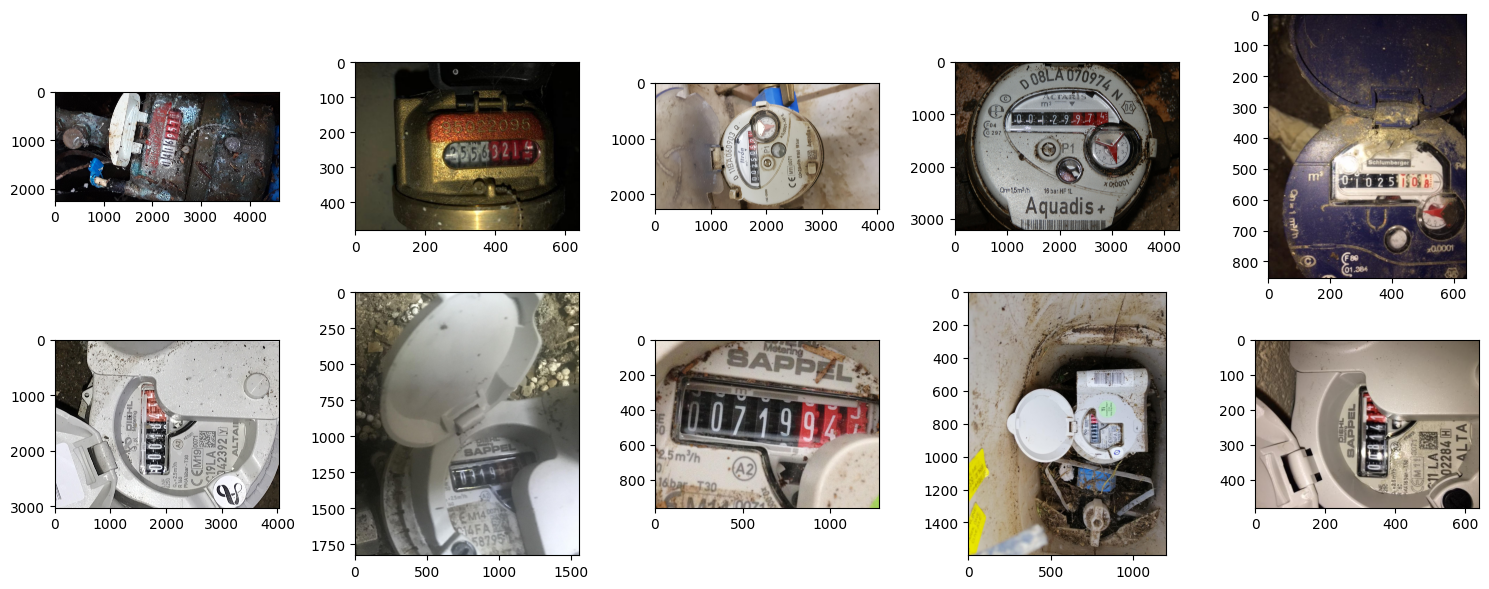

In [14]:
liste_images = os.listdir(filepath)
fig = plt.figure(figsize=(15,6))


for i, path_im in enumerate(liste_images[:10]):
    im = plt.imread(os.path.join(filepath, path_im))
    fig.add_subplot(2,5,i+1) ; plt.imshow(im)

plt.tight_layout()
plt.show()


On remarque que les images ne font pas toutes la même taille, que les numéros sont plus ou moins visibles. Comme ce sont les numéros qui nous intéressent, on peut remarquer une constance : un fond noir ou rouge, sur lequel sont affichés des numéros blancs.  Le reste de l'image n'est pas intéressant pour nous. On peut déja réfléchir à un nettoyage des images pour ne garder que cette partie qui nous intéresse. 

- En noir et blanc, c'est la valeur d'eau consommé en $m^3$
- En rouge et blanc, c'est la valeur d'eau consommé en litres.

Ce qui nous intéresse dans ce challenge, c'est d'obtenir la valeur des trois derniers numéros de la consommation en $m^3$.

In [27]:
y_train_csv = pd.read_csv('./datas/y_train.csv')
y_train_csv

,ID,index
0,0127d0,1416
1,012e2f,2556
2,01a650,250
3,0249c2,129
4,027912,1025
...,...,...
788,fe359d,216
789,fe5bf4,289
790,ff7912,624
791,ff9175,472


In [35]:
class WaterMeterDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (str): Chemin vers le fichier CSV.
            img_dir (str): Répertoire contenant les images.
            transform (callable, optional): Transformations à appliquer aux images.
        """
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0] + '.jpg')
        image = Image.open(img_name)
        label = self.data.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label)

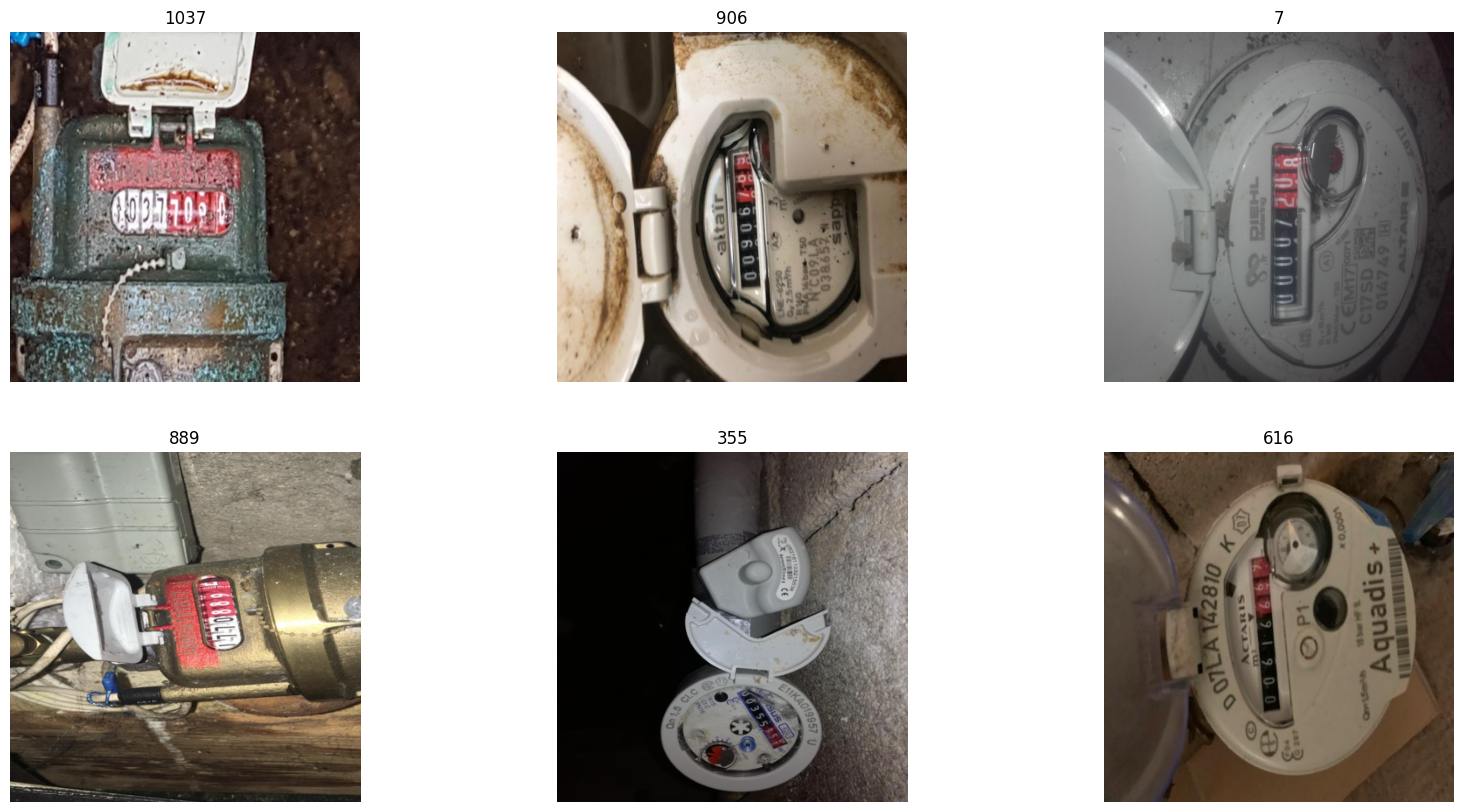

In [49]:
transform = transforms.Compose([
    transforms.Resize((400, 400)),  # Redimensionner les images
    transforms.ToTensor()
])

train_dataset = WaterMeterDataset(csv_file='datas/y_train.csv', img_dir='datas/XTRAIN/', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

fig = plt.figure(figsize=(20,10))
imgs, labels = next(iter(train_dataloader))
for i in range(6):
    fig.add_subplot(2,3,i+1) ; plt.imshow(ToPILImage()(imgs[i])), plt.title(labels[i].item()) ,plt.axis('off')

plt.show()

On constate certaines erreurs entre le label fourni et la réalité de l'image, par exemple pour l'image ```19d49d.jpg```, qui affiche **1770** $m^3$ et a pour label **889** (sa valeur en litres).

# 2. Repartition du dataset fourni

Il faut répartir les images dans trois dossiers ```/train/```, ```/val/```, ```/test/``` qui vont nous servir tout au long de l'apprentissage.

In [1]:
import os
import shutil
import random

source_dir = "datasets/x_train"

# Dossiers de destination
train_dir = "dataset/train"
val_dir = "dataset/val"
test_dir = "dataset/test"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


train_ratio = 0.75  # 75% pour l'entraînement
val_ratio = 0.15    # 15% pour la validation
test_ratio = 0.1   # 10% pour le test


# Liste des fichiers dans le dossier source
files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

# Mélanger les fichiers aléatoirement
random.shuffle(files)

# Calcul des tailles des ensembles
total_files = len(files)
train_size = int(total_files * train_ratio)
val_size = int(total_files * val_ratio)

# Répartir les fichiers dans les ensembles
train_files = files[:train_size]
val_files = files[train_size:train_size + val_size]
test_files = files[train_size + val_size:]

# Fonction pour déplacer les fichiers
def move_files(file_list, destination_dir):
    for file in file_list:
        shutil.move(os.path.join(source_dir, file), os.path.join(destination_dir, file))

# Déplacer les fichiers
move_files(train_files, train_dir)
move_files(val_files, val_dir)
move_files(test_files, test_dir)

print(f"[INFO] Répartition terminée :")
print(f" - Train : {len(train_files)} images")
print(f" - Val   : {len(val_files)} images")
print(f" - Test  : {len(test_files)} images")


[INFO] Répartition terminée :
 - Train : 594 images
 - Val   : 118 images
 - Test  : 81 images


# 3. Segmentation

On sent que pour arriver à nos fins, il serait idéal d'avoir une pipeline qui localise l'affichage du compteur (détection d'objets = cadran), qui l'isole, sur lequel on va ensuite appliquer des techniques d'OCR afin d'obtenir les numéros et ainsi estimer la consommation d'eau.

La première étape est donc de la **détection**. Pour se faire, un modèle très performant et reconnu est **YOLO** (version actuelle : 11). Maintenant, YOLO est entrainé pour reconnaitre tout un tas d'objets, mais pas vraiment de reconnaitre les cadrans de compteurs. Il faut alors le **finetune** pour avoir des résultats plus convaincants. 

## 3.1 Label des Bouncing Boxes d'entrainement.

--> cf le code ```annotation_manuelle.py```. 

## 3.2 Finetuning de YOLOV11

Cette partie a tourné sur *Google Colab* pour profiter du GPU. 

In [ ]:
# %pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.42  Python-3.10.7 torch-2.5.1+cpu CPU (12th Gen Intel Core(TM) i5-12450H)
Setup complete  (12 CPUs, 15.7 GB RAM, 314.6/337.2 GB disk)


In [ ]:
!yolo task=detect mode=train model=yolo11n.pt data=drive/MyDrive/AIforMeterReading/data.yaml epochs=20 imgsz=640

In [ ]:
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data=drive/MyDrive/AIforMeterReading/data.yaml imgsz=640

## 3.3 Detection et segmentation large (pour une seule image)

On peut prédire des boites englobantes en quelques lignes, et les afficher.

In [ ]:
from ultralytics import YOLO

image_name = "datasets/dataset/train/912ff1.jpg"
model_name = "bbox_yolov11_200train.pt" 

model = YOLO(model_name)
results = model.predict(source="image.jpg")

results[0].show()

Ce qui nous intéresse, c'est de segmenter pour ne garder que les parties intéressantes. Pour ça, on convertit les boites englobantes en des masques binaires, qu'on applique sur les images. Il ne nous restera plus que les cadrans pour la suite.

In [ ]:
# Charger l'image d'origine
image_path = "image.jpg"
original_image = cv2.imread(image_path)
height, width = original_image.shape[:2]  # Dimensions de l'image

# Extraire les boîtes englobantes et les scores de confiance
boxes = results[0].boxes  # Obtenir les boîtes
if len(boxes) > 0:
    xyxy = boxes.xyxy.cpu().numpy()  # Coordonnées (x_min, y_min, x_max, y_max)
    confidences = boxes.conf.cpu().numpy()  # Scores de confiance

    # Trouver la boîte avec le score de confiance le plus élevé
    max_idx = np.argmax(confidences)
    best_box = xyxy[max_idx]  # Coordonnées de la meilleure boîte
    x_min, y_min, x_max, y_max = map(int, best_box)

    # Créer un masque binaire
    mask = np.zeros((height, width), dtype=np.uint8)
    mask[y_min:y_max, x_min:x_max] = 255  # Région détectée en blanc

    masked_image = cv2.bitwise_and(original_image, original_image, mask=mask)

    # Visualiser le masque binaire
    fig = plt.figure(figsize=(16, 8))
    fig.add_subplot(1,3,1), plt.title("Image originale")
    plt.imshow(original_image)
    plt.axis("off")
    fig.add_subplot(1,3,2), plt.title("Masque Binaire (Meilleure Boîte)")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    fig.add_subplot(1,3,3), plt.title("Combinaison")
    plt.imshow(masked_image)
    plt.axis("off")
    plt.show()

    print(f"Boîte sélectionnée : {x_min}, {y_min}, {x_max}, {y_max}")
else:
    print("[INFO] Aucune boîte détectée.")